<a href="https://colab.research.google.com/github/thxsxth/POMDP_RLSepsis/blob/master/Physiology_informed_Sequential_AutoEncoder_(With_Denoising).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
cd 'drive/My Drive/sepsis3-cohort'

/content/drive/My Drive/sepsis3-cohort


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import random
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import os
import glob
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
import torch.nn.init as weight_init
import scipy
device='cuda' if torch.cuda.is_available() else 'cpu'

## Necessary Data Imports and PreProcessing

In [8]:
from load_and_process import *
print('Done')

Done


### Helper Function to mask the data

## DataSet and DataLoader

In [9]:
patient_list=list(np.load('new_pats.npy'))
valid_cohort=list(np.load('valid_cohort.npy'))

In [11]:
training_cohort=np.random.choice(a=patient_list, size=int(0.8*len(patient_list)), replace=False, p=None)
train_dataset=modeling_dataset(training_cohort,T_max=90)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,collate_fn=collate_model)

In [ ]:
full_dataset=modeling_dataset(patient_list,T_max=48)
full_loader=DataLoader(full_dataset,batch_size=16,shuffle=True,collate_fn=collate_model)

In [12]:
valid_cohort=list(set(patient_list)-set(training_cohort))
valid_dataset=modeling_dataset(valid_cohort,T_max=90)
valid_loader=DataLoader(valid_dataset,batch_size=16,shuffle=False,collate_fn=collate_model)

### Testing if the DataLoader works as expected

In [ ]:
for i,(trajectories,treatments,constants,mask,seq_lens,obs,others) in enumerate(valid_loader):
  print(trajectories.shape)
  print(treatments.shape)
  print(constants.shape)
  print(obs.shape)

  if i==2:
    break

### Let's define the networks

In [14]:
class patient_encoder(nn.Module):

  """
  Takes constant demographic details and possibly labs and encodes into  z_0, h_0
  h_0 is the initial state for the RNN
  DO NOT WANT z_0=h_0
  """

  def __init__(self,constant_dim,z_dim=5,h_dim=64,hidden_dim=64,n_layers=3):
    
    super(patient_encoder,self).__init__()
    self.linear_input=nn.Linear(constant_dim,hidden_dim)
    self.h0=nn.Linear(hidden_dim,h_dim)
    self.z_0=nn.Linear(hidden_dim,z_dim)
    self.hidden_layers=nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.ELU()) for i in range(n_layers)])
        
  def forward(self,x):
    """
    x=constants(+ may be initial_labs)
    """
    x=F.elu(self.linear_input(x)) #batch_size*hidden_dim

    for layer in self.hidden_layers:
      x=layer(x)
    
    h0=self.h0(x)
    z0=self.z_0(x)   
    
    # z_sigma=F.softplus(self.z_sigma(x))

    return z0,h0

### Mechanistic Model Based on Cardiovascular Physiology

In [15]:
def mechanistic(Z):
  """
  Z should be torch.Tensor
  Z.shape =B*5
  Z[:,0]=HR,Z[:,1]=R_a, Z[:,2]=C_a, Z[:,3]=T , Z[:,4]=SV
  Obs Dim=4

  """
  obs=torch.zeros((Z.shape[0],4))
 
  
  # HR=Z[:,0]  #B
  # R=Z[:,1]
  # C=Z[:,2]
  # T=Z[:,3]
  # SV=Z[:,4]
  
  # obs[:,0]=HR
  # obs[:,1]=(SV/C)*(1/(1-torch.exp(-T/(R*C))))
  # obs[:,2]=obs[:,1]*torch.exp(-T/(R*C))
  # obs[:,3]=(SV/60)*HR*R

  obs[:,0]=Z[:,0]
  obs[:,1]=(Z[:,4]/Z[:,2])*(1/(1-torch.exp(-Z[:,3]/(Z[:,1]*Z[:,2]))))
  obs[:,2]=(torch.exp(-Z[:,3]/(Z[:,1]*Z[:,2])))*(Z[:,4]/Z[:,2])*(1/(1-torch.exp(-Z[:,3]/(Z[:,1]*Z[:,2]))))
  obs[:,3]=(Z[:,4]/60)*Z[:,0]*Z[:,1]


  return obs.to(device)

### Deterministic

In [16]:
class Encoder(nn.Module):
  """ Encodes x_{:t} 
      The job of the Encoder is to remember the past observations.
     
  """

  def __init__(self,obs_dim,h_dim,a_dim,n_layers=1, dropout=0.0):
      
      super(Encoder,self).__init__()
      
      self.rnn=nn.GRU(obs_dim,h_dim,n_layers,batch_first=True)
      self.dropout=dropout  
      self.n_layers=n_layers
      self.hidden_dim=h_dim

    
      
      # self.init_h = nn.Parameter(torch.randn(n_layers,1,
      #                                        h_dim), requires_grad=True)
      self.init_weights()

  def  init_weights(self):
        for w in self.rnn.parameters(): # initialize the gate weights with orthogonal
            if w.dim()>1:
                weight_init.orthogonal_(w)

  def forward(self,full_obs,obs_lens,patient_demos,init_h=None, noise=False):

    """
    USING FULL_OBS for the moment, but later let's may be only use the 4d Obs
    
    obs: A mini batch of observations B*T*D
    obs_lens=observation lengths to pack pad sequences
    patient_demos: Batch of size B*pat_dim (=C)
    """
    batch_size, max_len, freq=full_obs.size()
    
    obs_lens=torch.LongTensor(obs_lens).to(device)
    obs_lens_sorted, indices = obs_lens.sort(descending=True)
    obs_sorted = full_obs.index_select(0, indices)  
    
    packed_obs=pack_padded_sequence(obs_sorted,obs_lens_sorted.data.tolist(),batch_first=True)
    # if init_h is None:
    #     init_h=self.init_h

    init_h=init_h.unsqueeze(0) #1*B*H
    
    
    hids, h_n = self.rnn(packed_obs, init_h) # hids: [B x T x H]  
                                                  # h_n: [num_layers*B*H)
    _, inv_indices = indices.sort()

    hids, lens = pad_packed_sequence(hids, batch_first=True)         
    hids = hids.index_select(0, inv_indices) 
    
            
    return hids

In [17]:
class Transition(nn.Module):
    """
    Deterministically Computes Z_t based on h_t,z_t_1,a_t
    using a MLP, where z is latent and a is the action
    Modified from https://pyro.ai/examples/dmm.html
    """
    def __init__(self, z_dim,a_dim,h_dim,constant_dim, hidden_dim=128,n_layers=8,mu_layers=4):
      super(Transition,self).__init__()
      
      input_dim=z_dim+a_dim+h_dim+constant_dim
      self.bn=nn.BatchNorm1d(input_dim)
      self.input_to_h=nn.Linear(input_dim, hidden_dim)
      
      self.hidden_layers=nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.ELU()) for i in range(n_layers)])
      self.z=nn.Linear(hidden_dim,z_dim)
      

   
    def forward(self,z_prev,a_t,h_t,constants):
  
      # concatenate the latent z and actions along the frequency dimension
      input_=torch.cat([z_prev,a_t,h_t,constants],dim=1)
        #B*K*(D+T) let's call D+T=F
      
      # input_=self.bn(input_)
      input_=self.input_to_h(input_)
      
      for layer in self.hidden_layers:
        input_=layer(input_)     #B*K*H
      

      
      z=self.z(input_)
                           
      return z

In [ ]:
class Emitter(nn.Module):
    """
    O_t based on Z_t
    """
    def __init__(self, z_dim,a_dim,h_dim,constant_dim, hidden_dim=128,n_layers=8):
      super(Transition,self).__init__()
      
      input_dim=z_dim+a_dim+h_dim+constant_dim
      self.bn=nn.BatchNorm1d(input_dim)
      self.input_to_h=nn.Linear(input_dim, hidden_dim)
      
      self.hidden_layers=nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.ELU()) for i in range(n_layers)])
      self.z=nn.Linear(hidden_dim,z_dim)
      

   
    def forward(self,z_prev,a_t,h_t,constants):
  
      # concatenate the latent z and actions along the frequency dimension
      input_=torch.cat([z_prev,a_t,h_t,constants],dim=1)
        #B*K*(D+T) let's call D+T=F
      
      # input_=self.bn(input_)
      input_=self.input_to_h(input_)
      
      for layer in self.hidden_layers:
        input_=layer(input_)     #B*K*H
      

      
      z=self.z(input_)
                           
      return z

In [18]:
class state_space(nn.Module):
  
  def __init__(self,z_dim,obs_dim,full_dim,h_dim,a_dim,constants_dim):
    
    super(state_space,self).__init__()

    self.rnn=Encoder(full_dim,h_dim,a_dim)
    self.trans=Transition(z_dim,a_dim,h_dim,constants_dim)
    self.z_baselines=torch.FloatTensor([70.0,1.0,2.0,0.7,70.0]).to(device)
    self.initial=patient_encoder(constants_dim,z_dim,h_dim)
    
    if device=='cuda':
      self.cuda()

  def forward(self,trajectories,treatments,constants,mask,seq_lens,obs):
      """
      trajectories : Batch of Full_observations B*T*|Full_O|
      seq_lengths :list
      actions : B*T*|A|
      Constants B*|C|
      obs : B*T*|O|
      others : B*T*(|Full_O|-|O|)
      """
      
      T_max =trajectories.size(1)
      batch_size=trajectories.size(0)
      baselines=self.z_baselines.expand(batch_size,-1)
      z_prev,h_prev=self.initial(constants)
    
      h_prev=h_prev.contiguous()
      
      outputs=[]

      a_prev=torch.zeros(treatments.shape[0],treatments.shape[2]).to(device) #B*A
      rnn_output=self.rnn(trajectories,seq_lens,constants,h_prev) 
   
       #rnn_ouput has shape B*T*H

      # we enclose all the sample statements in the model in a plate.
      # this marks that each datapoint is conditionally independent of the others
      
      for t in range(1,T_max+1):

        z_t=self.trans(z_prev,a_prev,rnn_output[:,t-1,:],constants)
        z_scaled=z_t+baselines
        
        o_t=mechanistic(z_scaled) #B*obs_dim
        outputs.append(o_t)
        
        z_prev = z_t
        a_prev=treatments[:,t-1,:]
         
           
      temp=torch.stack(outputs,dim=1).to(device)
      return temp  #Batch_size*T*Obs_dim


#### Defining the Model and Optimizer

In [19]:
model=state_space(z_dim=5,obs_dim=4,full_dim=12,h_dim=64,a_dim=2,constants_dim=3)
# model=state_space(z_dim=5,obs_dim=4,full_dim=12,h_dim=512,a_dim=2,constants_dim=3)
# model2=state_space(z_dim=5,obs_dim=4,full_dim=12,h_dim=64,a_dim=2,constants_dim=3)
loss=nn.MSELoss(reduction='none')
optimizer=optim.Adam(model.parameters(),lr=1e-5)
# optimizer=optim.Adam(model2.parameters(),lr=1e-5)

In [21]:
def train_epoch(epoch,model,train_loader, criterion, optimizer,p=0.1):

  model.train()
  sum_loss = 0

  for batch_num,(trajectories,treatments,constants,mask,seq_lens,obs,others) in enumerate(train_loader):
    
    if min(seq_lens)<5:
      continue


    batch_num+=1
    with torch.autograd.set_detect_anomaly(True):
      optimizer.zero_grad()

      random_mask=(torch.FloatTensor(trajectories.shape[0],trajectories.shape[1],trajectories.shape[2]).uniform_() >p).to(device) 
      trajectories=trajectories*random_mask
      # trajectories=trajectories[:,:-1,:]
      # seq_lens=[len-1 for len in seq_lens]
      out_=model(trajectories,treatments,constants,mask,seq_lens,obs) #B*T*Obs

      predictions = out_.contiguous().view(-1, out_.size(-1))  #(B*T)*Obs
      # print(predictions.shape)
      # obs=obs[:,1:,:]
      obs_=obs.contiguous().view(-1,obs.size(-1))  #(B*T)*Obs

      loss = criterion(predictions,obs_)  #(B*T)*Obs
      # mask=mask[:,1:]
      mask_=mask.contiguous().view(-1,1) #(B*T)*1
      
      masked_loss = torch.sum(loss*mask_)
      
      # sum_loss+=masked_loss.item()
      
      masked_loss.backward()
      
      torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
      optimizer.step()

      current_loss = float(masked_loss.item())/int(torch.sum(mask).item())

      print('Epoch ', epoch, 'Current Loss',current_loss)
      
      sum_loss+=current_loss
      av_loss=sum_loss/(batch_num)
      print('Average Loss is :',av_loss)

print('Done')

Done


In [23]:

def evaluate(model,valid_loader,criterion):
   sum_loss=0
   model.eval()
   
   print('Validating')

   for batch_num,(trajectories,treatments,constants,mask,seq_lens,obs,others) in enumerate(valid_loader):
     batch_num+=1
     if min(seq_lens)<5:
      continue
     with torch.no_grad():
        # trajectories=trajectories[:,:-1,:]
        # seq_lens=[len-1 for len in seq_lens]
        out_=model(trajectories,treatments,constants,mask,seq_lens,obs)
        predictions = out_.contiguous().view(-1, out_.size(-1))  #(B*T)*Obs
        # print(predictions.shape)
        # obs=obs[:,1:,:]
        obs_=obs.contiguous().view(-1,obs.size(-1))  #(B*T)*Obs

        loss = criterion(predictions,obs_) #(B*T)*Obs
        
        # mask=mask[:,1:]
        mask_=mask.contiguous().view(-1,1) #(B*T)*1
        masked_loss = torch.sum(loss*mask_)
        current_loss = float(masked_loss.item())/int(torch.sum(mask).item())

        print('Val Current Loss',current_loss)
      
        sum_loss+=current_loss
        av_loss=sum_loss/(batch_num)
        
        print('Average Validation Loss is :',av_loss)


   model.train()

   return av_loss  






print('Done')

Done


In [ ]:
cd physio

In [23]:
ls

denoise_auto_0.15.pt                denoise_auto_21.14946742157139.pt
denoise_auto_0.5.pt                 denoise_auto_21.27327754376229.pt
denoise_auto_19.03568517701071.pt   denoise_auto_22.28249618758459.pt
denoise_auto_19.292082309881536.pt  denoise_auto_24.59860025552893.pt
denoise_auto_19.47176710134285.pt   denoise_auto_24.798284542387346.pt
denoise_auto_20.017858770721816.pt  denoise_auto_24.989851851415093.pt
denoise_auto_20.442816033995523.pt  denoise_auto_25.261256060555127.pt
denoise_auto_20.698103513470638.pt  denoise_auto_27.926003456642675.pt


In [25]:
# model.load_state_dict(torch.load('../noisy_ deterministic_{}.pt',map_location=torch.device('cpu')))
model.load_state_dict(torch.load('denoise_auto_19.03568517701071.pt',map_location=device))

<All keys matched successfully>

In [ ]:
# torch.save(model.state_dict(), 'denoise_auto_{}.pt'.format(p))


In [ ]:
cd physio

/content/drive/My Drive/sepsis3-cohort/physio


In [ ]:
import numpy as np
best_val_loss=19.2
num_epochs=100
p=0.1
for epoch in range(1,num_epochs):
  print('Epoch :', epoch,'p =',p)
  train_epoch(epoch,model,train_loader,loss, optimizer,p)

  val_loss=evaluate(model,valid_loader,loss)
  
  if val_loss<best_val_loss:
    best_val_loss=val_loss
    print(' Best Val Loss ',val_loss)
    torch.save(model.state_dict(), '{}_denoise_auto_{}.pt'.format(p,val_loss))

  # p=p+0.0025
  if epoch%5==0:
    torch.save(model.state_dict(), 'denoise_auto_{}.pt'.format(p))
    p=p+0.010
    p=min(p,0.5)
  



## Testing out and Analyzing (Ignore!)

In [ ]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels


def plot_cv_paramters(seq_len,vaso,fluids,cvs):

  """
  seq_len : The seq lens of the patient
  Vaso: Vasopressors Sequence : torch.tensor
  Fluids: Fluids Sequence torch.tensor
  cvs : CV (Hidden Varaibles) outputs from the model torch.tensor

  """
  plt.figure(figsize=(30,30))
  plt.subplot(3, 2, 1)
  plt.title('Vasopressor Dosage', fontsize=20)

  plt.plot(np.arange(seq_len),vaso.numpy(),marker='o',color='g',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 2)
  plt.title('Fluids', fontsize=20)
  plt.plot(np.arange(seq_len),fluids.numpy(),marker='.',color='b',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 3)
  plt.title('Resistance', fontsize=20)
  plt.plot(np.arange(seq_len),cvs[:,1].numpy(),marker='x',color='k',linestyle='dotted',linewidth=2)


  plt.subplot(3, 2, 4)
  plt.title('Compliance', fontsize=20)
  plt.plot(np.arange(seq_len),cvs[:,2].numpy(),marker='x',color='r',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 5)
  plt.title('Heart Rate', fontsize=20)
  plt.plot(np.arange(seq_len),cvs[:,0].numpy(),marker='x',color='r',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 6)
  plt.title('SV*R', fontsize=20)
  plt.plot(np.arange(seq_len),cvs[:,4].numpy(),marker='x',color='r',linestyle='dotted',linewidth=2)

  plt.show()
  # plt.savefig('identifiables.jpg')

In [40]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels


def plot_cv_state(seq_len,vaso,fluids,cvs):

  """

  seq_len : The seq lens of the patient
  Vaso: Vasopressors Sequence : torch.tensor
  Fluids: Fluids Sequence torch.tensor
  cvs : CV (Hidden Varaibles) outputs from the model torch.tensor

  Plots SV/C and RC, SVR

  """
  plt.figure(figsize=(30,30))
  plt.subplot(3, 2, 1)
  plt.title('Vasopressor Dosage', fontsize=20)

  plt.plot(np.arange(seq_len),vaso.numpy(),marker='o',color='g',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 2)
  plt.title('Fluids', fontsize=20)
  plt.plot(np.arange(seq_len),fluids.numpy(),marker='.',color='b',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 3)
  plt.title('SV/C', fontsize=20)
  plt.plot(np.arange(seq_len),(cvs[:,4]/cvs[:,2]).numpy(),marker='x',color='k',linestyle='dotted',linewidth=2)


  plt.subplot(3, 2, 4)
  plt.title('RC', fontsize=20)
  plt.plot(np.arange(seq_len),(cvs[:,2]*cvs[:,1]).numpy(),marker='x',color='r',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 5)
  plt.title('(CO)*R', fontsize=20)
  plt.plot(np.arange(seq_len),(cvs[:,0]*cvs[:,4]*cvs[:,1]).numpy(),marker='x',color='r',linestyle='dotted',linewidth=2)

  plt.subplot(3, 2, 6)
  plt.title('(SV)*R', fontsize=20)
  plt.plot(np.arange(seq_len),(cvs[:,4]*cvs[:,1]).numpy(),marker='x',color='r',linestyle='dotted',linewidth=2)

  plt.show()
  # plt.savefig('complete_cv_state.jpg')

In [27]:

def plot_outputs(seq_len,obs,out):
  titles=['Heart Rate','Systolic BP','Diastolic BP','Mean BP']
  fig = plt.figure(figsize=(50,50))
  for i in range(1, 5):
    
    ax = fig.add_subplot(2, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')
    
    ax.plot(np.arange(seq_len),obs[:,i-1].numpy(),marker='x',color='r',linestyle='dotted',linewidth=3)
    ax.plot(np.arange(seq_len),out[:,i-1].detach().numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)
    plt.title(titles[i-1], fontsize=30)
    # plt.tick_params(axis='x', colors='white')
    # plt.tick_params(axis='y', colors='white')
    




In [29]:
class state_space_new(nn.Module):
  
  def __init__(self,z_dim,obs_dim,full_dim,h_dim,a_dim,constants_dim):
    
    super(state_space_new,self).__init__()

    self.rnn=Encoder(full_dim,h_dim,a_dim)
    self.trans=Transition(z_dim,a_dim,h_dim,constants_dim)
    self.z_baselines=torch.FloatTensor([70.0,1.0,2.0,0.7,70.0]).to(device)
    self.initial=patient_encoder(constants_dim,z_dim,h_dim)
    
    if device=='cuda':
      self.cuda()

  def forward(self,trajectories,treatments,constants,mask,seq_lens,obs):
      """
      trajectories : Batch of Full_observations B*T*|Full_O|
      seq_lengths :list
      actions : B*T*|A|
      Constants B*|C|
      obs : B*T*|O|
      others : B*T*(|Full_O|-|O|)
      """
      
      T_max =trajectories.size(1)
      batch_size=trajectories.size(0)
      baselines=self.z_baselines.expand(batch_size,-1)
      z_prev,h_prev=self.initial(constants)
    
      h_prev=h_prev.contiguous()
      
      outputs=[]
      cv_params=[]

      a_prev=torch.zeros(treatments.shape[0],treatments.shape[2]).to(device) #B*A
      rnn_output=self.rnn(trajectories,seq_lens,constants,h_prev) 
   
       #rnn_ouput has shape B*T*H

      # we enclose all the sample statements in the model in a plate.
      # this marks that each datapoint is conditionally independent of the others
      
      for t in range(1,T_max+1):

        z_t=self.trans(z_prev,a_prev,rnn_output[:,t-1,:],constants)
        z_scaled=z_t+baselines
        
        o_t=mechanistic(z_scaled) #B*obs_dim
        outputs.append(o_t)
        cv_params.append(z_scaled)
        
        z_prev = z_t
        a_prev=treatments[:,t-1,:]
         
           
      temp=torch.stack(outputs,dim=1).to(device)
      cv=torch.stack(cv_params,dim=1).to(device)
      return temp,cv


In [30]:
ls

0.1_denoise_auto_17.763059199264546.pt  denoise_auto_20.698103513470638.pt
0.1_denoise_auto_18.199223333661593.pt  denoise_auto_21.14946742157139.pt
denoise_auto_0.15.pt                    denoise_auto_21.27327754376229.pt
denoise_auto_0.5.pt                     denoise_auto_22.28249618758459.pt
denoise_auto_19.03568517701071.pt       denoise_auto_24.59860025552893.pt
denoise_auto_19.292082309881536.pt      denoise_auto_24.798284542387346.pt
denoise_auto_19.47176710134285.pt       denoise_auto_24.989851851415093.pt
denoise_auto_20.017858770721816.pt      denoise_auto_25.261256060555127.pt
denoise_auto_20.442816033995523.pt      denoise_auto_27.926003456642675.pt


In [32]:
model=state_space_new(z_dim=5,obs_dim=4,full_dim=12,h_dim=64,a_dim=2,constants_dim=3)
# model.load_state_dict(torch.load('./Auto Encoder dicts/deterministic_final.pt'))
model.load_state_dict(torch.load('0.1_denoise_auto_17.763059199264546.pt'))



<All keys matched successfully>

In [ ]:
fig = plt.figure(figsize=(30,30))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')
    plt.plot(np.arange(seq_lens[pat]),obs8[:,i-1].numpy(),marker='x',color='r',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(seq_lens[pat]),out8[:,i-1].numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)
    # plt.tick_params(axis='x', colors='white')
    # plt.tick_params(axis='y', colors='white')
# plt.savefig('pat_{}_obs.jpg'.format(pat))

In [33]:
dead_pats=[]
lens=[]
for pat in valid_cohort:
  if co.loc[pat].	HOSPITAL_EXPIRE_FLAG==1:
    dead_pats.append(pat)
    lens.append(co.loc[pat].hosp_los)
    

In [34]:
dead_list=dead_pats

In [35]:
dead_dataset=modeling_dataset(dead_list,T_max=90)
dead_loader=DataLoader(dead_dataset,batch_size=len(dead_list),shuffle=False,collate_fn=collate_model)

In [ ]:
p=0.1
model.eval()
with torch.no_grad():
  for batch_num,(trajectories,treatments,constants,mask,seq_lens,obs,others) in enumerate(dead_loader):
    random_mask=(torch.FloatTensor(trajectories.shape[0],trajectories.shape[1],trajectories.shape[2]).uniform_() >p).to(device) 
    trajectories=trajectories*random_mask

    outputs,cvs=model(trajectories,treatments,constants,mask,seq_lens,obs)

In [ ]:
seq_lens

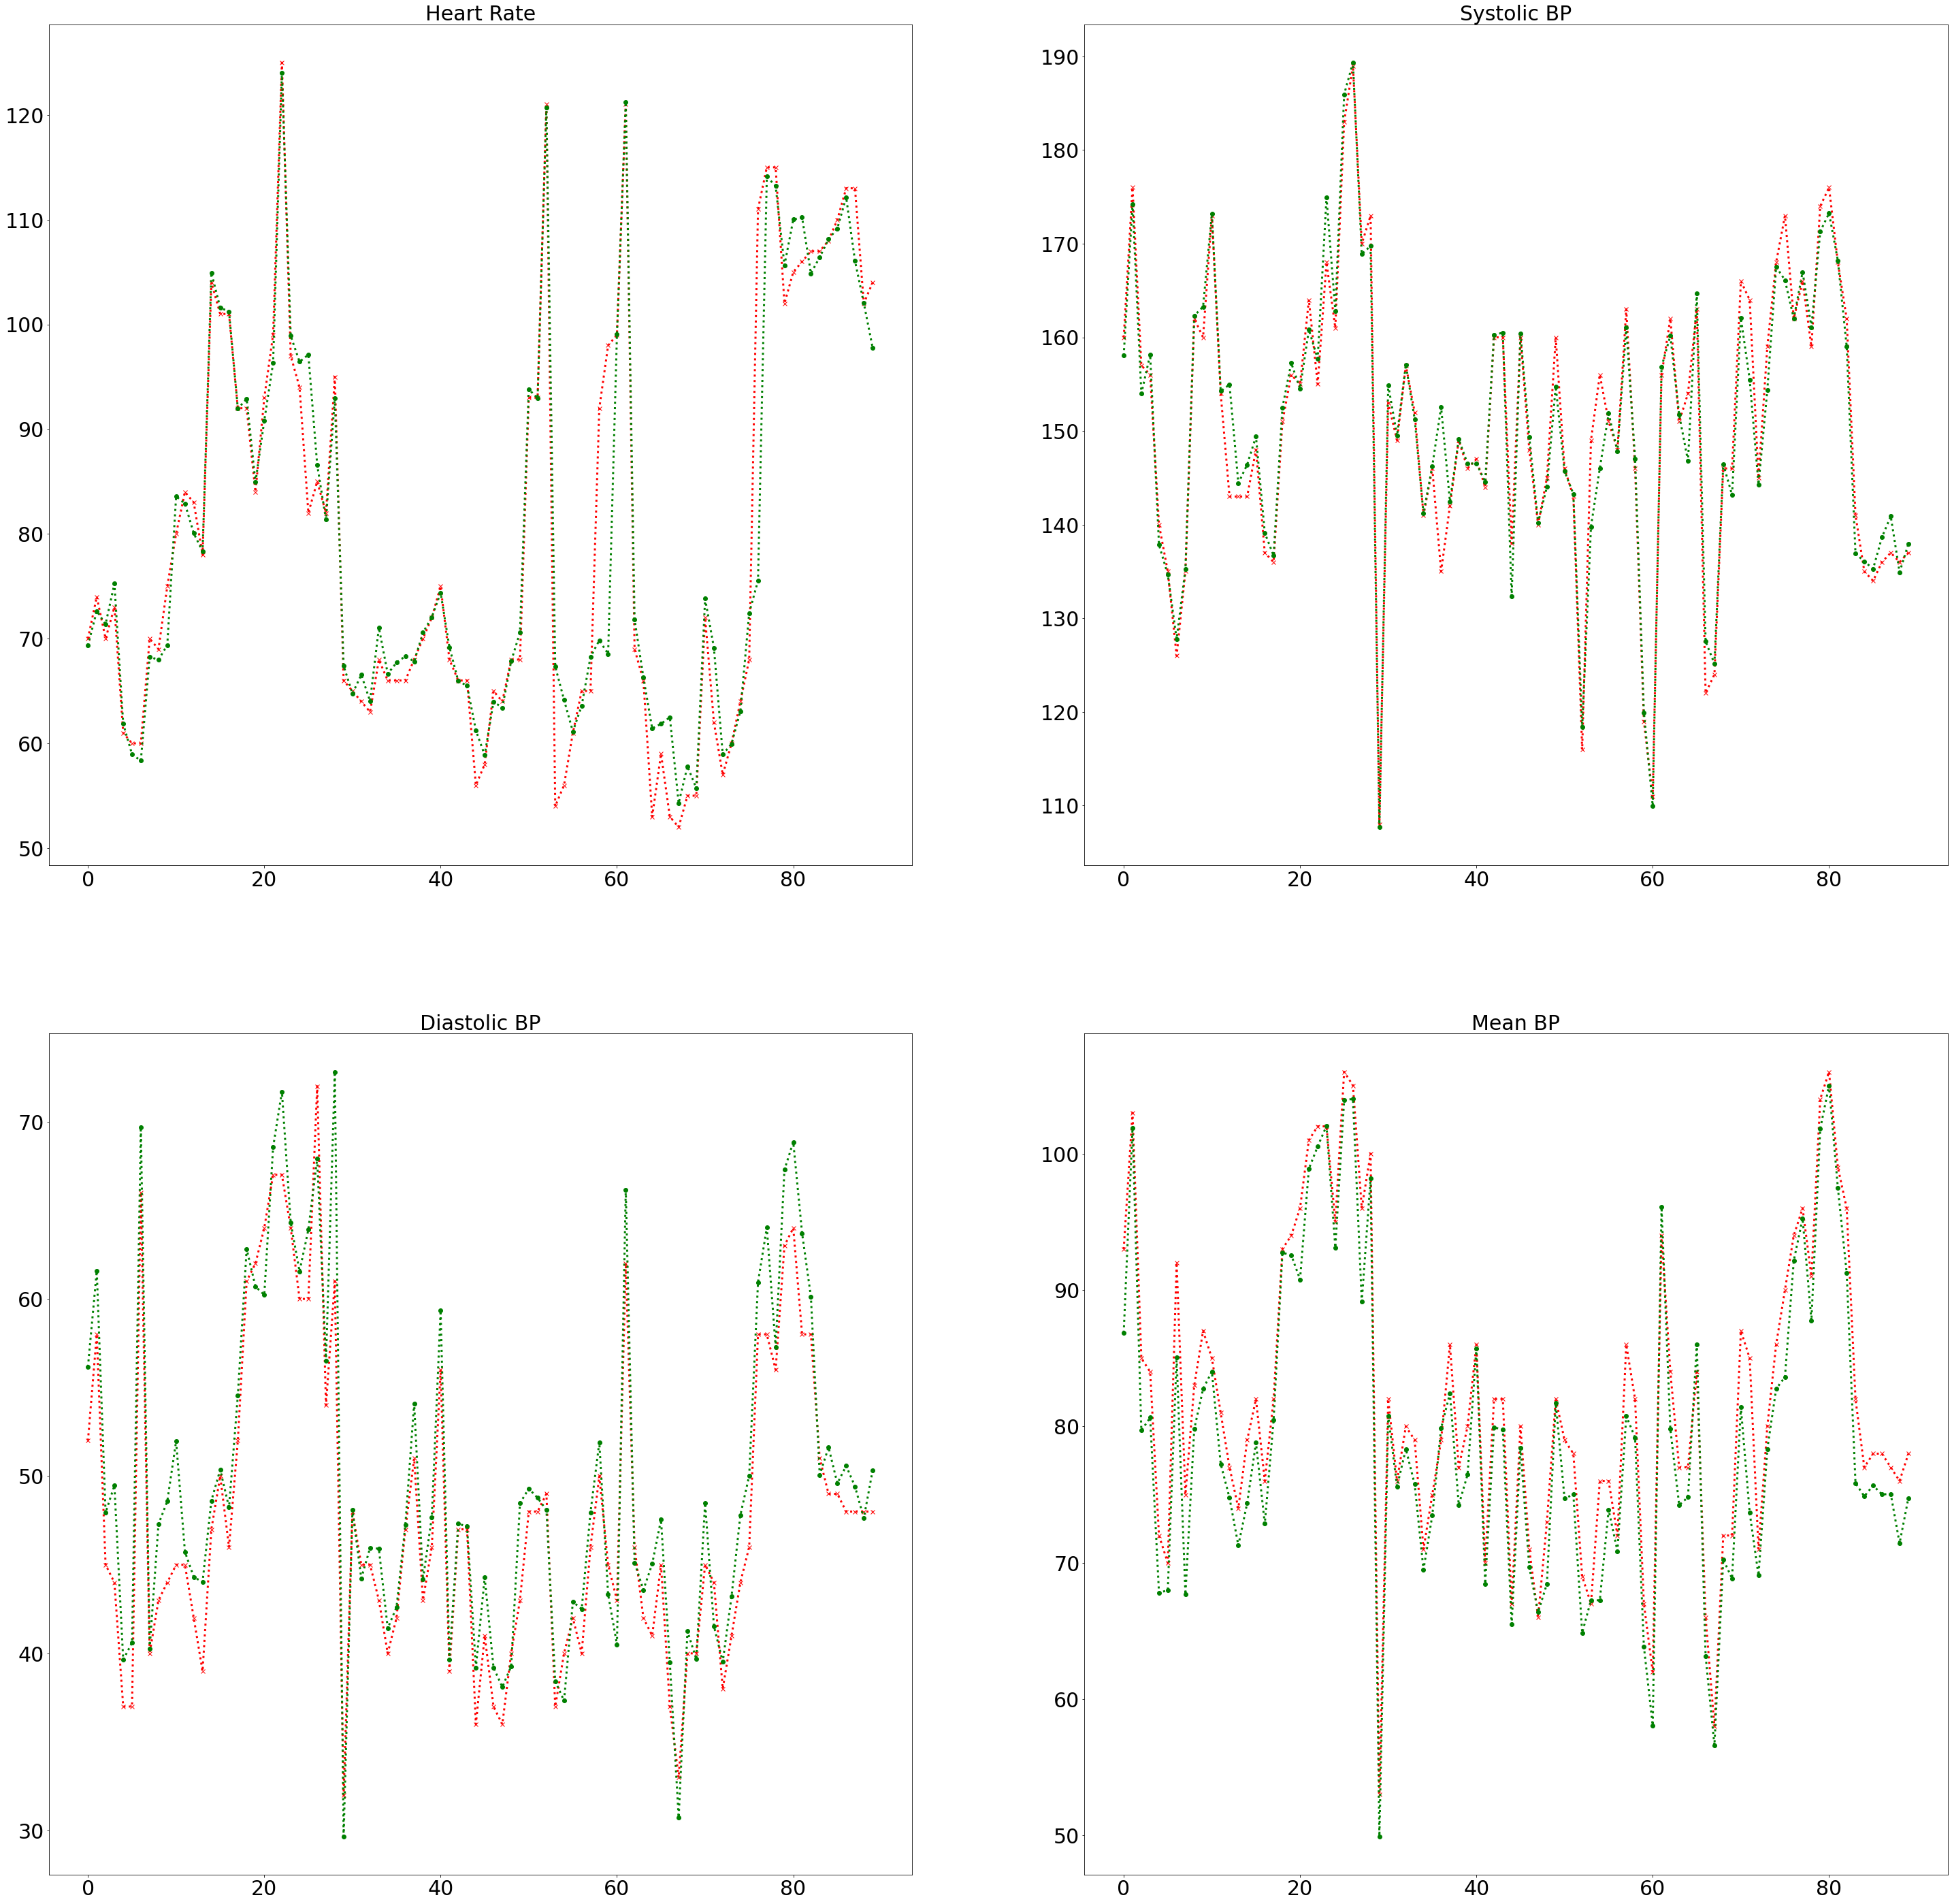

In [52]:
pat=np.random.choice(len(dead_list))
plot_outputs(seq_lens[pat],obs[pat,:seq_lens[pat],:],outputs[pat,:seq_lens[pat],:])

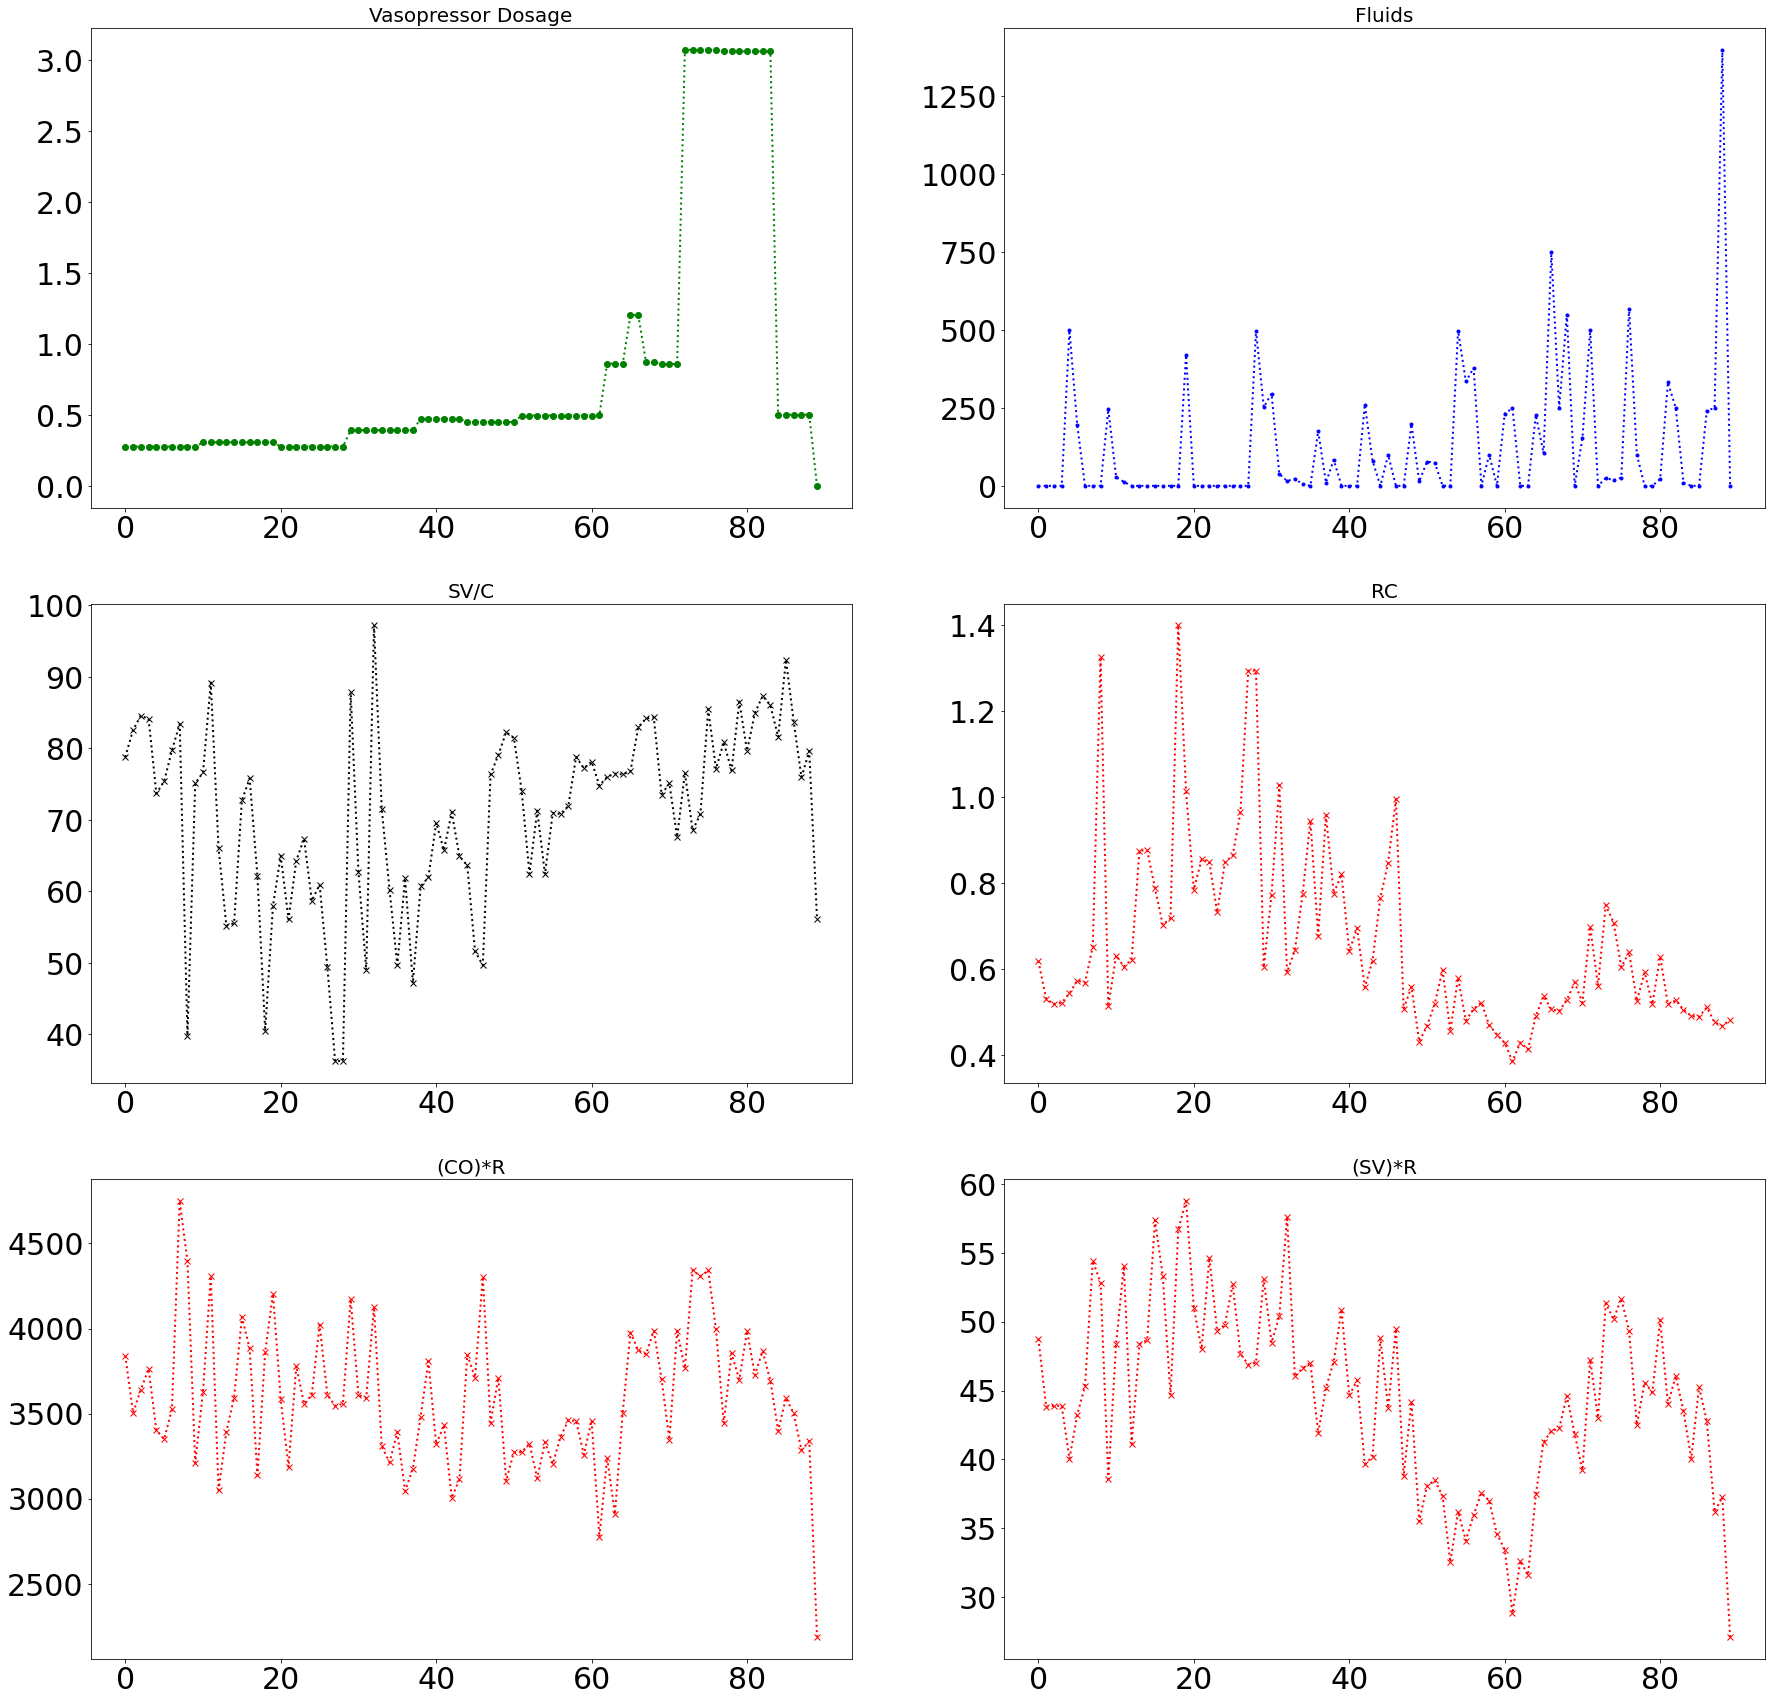

In [54]:
pat=np.random.choice(len(dead_list))
plot_cv_state(seq_lens[pat],treatments[pat,:seq_lens[pat],0],treatments[pat,:seq_lens[pat],1],cvs[pat,:seq_lens[pat],:])

In [ ]:
plot_cv_paramters(lens[4],treatments[4,:lens[4],0],treatments[4,:lens[4],1],cvs[4,:lens[4],:])

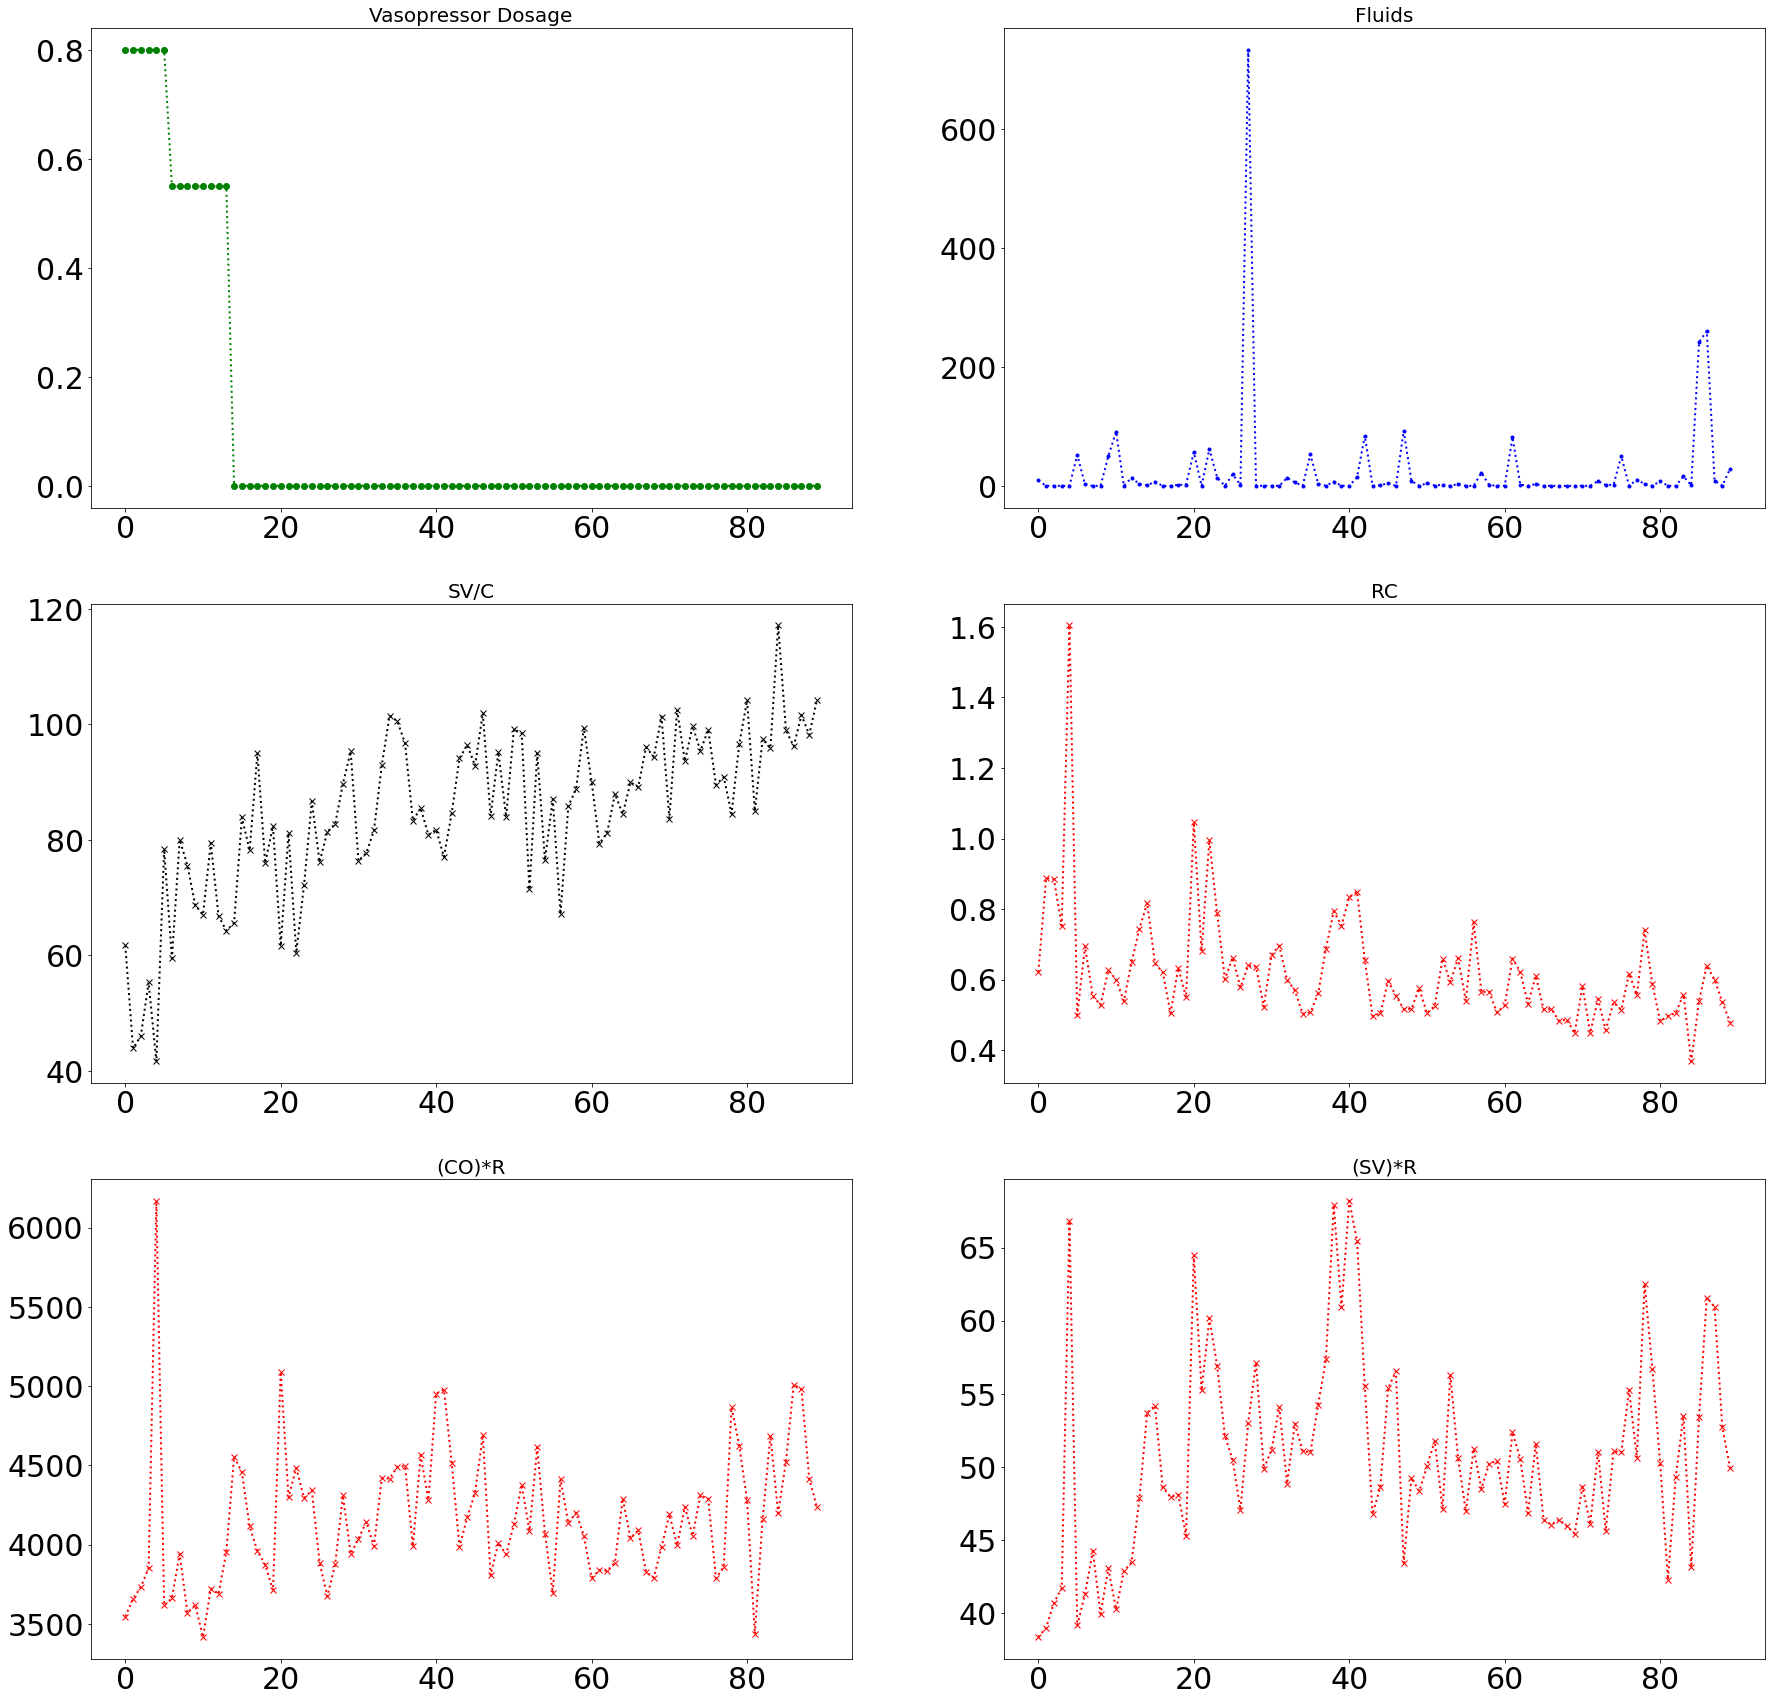

In [55]:
pat=np.random.choice(len(dead_pats))
plot_cv_state(seq_lens[pat],treatments[pat,:seq_lens[pat],0],treatments[pat,:seq_lens[pat],1],cvs[pat,:seq_lens[pat],:])

In [ ]:
dead_list[pat]

In [ ]:
test_dataset_=modeling_dataset([dead_list[pat]],T_max=90)
dead_loader_=DataLoader(test_dataset_,batch_size=1,shuffle=False,collate_fn=collate_model)

In [ ]:
# dead_dataset=modeling_dataset(pats2,T_max=90)
# dead_loader=DataLoader(dead_dataset,batch_size=50,shuffle=False,collate_fn=collate_model)

In [ ]:
# dead_dataset=modeling_dataset(pats2,T_max=90)
# dead_loader=DataLoader(dead_dataset,batch_size=50,shuffle=False,collate_fn=collate_model)
model.eval()
with torch.no_grad():
  for batch_num,(trajectories_,treatments_,constants_,mask_,seq_lens_,obs_,others_) in enumerate(dead_loader_):

    outputs,cvs=model(trajectories_,treatments_,constants_,mask_,seq_lens_,obs_)

In [ ]:
treatments1=torch.zeros_like(treatments_)
outputs1,cvs1=model(trajectories_,treatments1,constants_,mask_,seq_lens_,obs_)

In [ ]:
fig = plt.figure(figsize=(30,30))
for i in range(1, 6):
    plt.subplot(3, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')
    plt.plot(np.arange(seq_lens_[0]),cvs[:,:,i-1].squeeze(0).numpy(),marker='x',color='r',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(seq_lens_[0]),cvs1[:,:,i-1].detach().squeeze(0).numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)

In [ ]:
fig = plt.figure(figsize=(30,30))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')
    plt.plot(np.arange(seq_lens[pat]),obs8[:,i-1].numpy(),marker='x',color='r',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(seq_lens[pat]),out8[:,i-1].numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)